# Algorithmic Trading Model for Exponential Moving Average Crossover Grid Search

## Task 1. Prepare Environment

In [1]:
!pip install python-dotenv PyMySQL

In [2]:
# Retrieve CPU information from the system
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 2


In [3]:
import os
import sys
import smtplib
import numpy as np
import pandas as pd
import requests
import json
from email.message import EmailMessage
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from dotenv import load_dotenv

In [4]:
# Begin the timer for the script processing
startTimeScript = datetime.now()

# Set up the verbose flag to print detailed messages for debugging (setting True will activate!)
verbose = True

# Set up the sendNotification flag to send progress emails (setting True will send emails!)
notifyStatus = False

# Set up the parent directory location for loading the dotenv files
useColab = True
if useColab:
    # Mount Google Drive locally for storing files
    from google.colab import drive
    drive.mount('/content/gdrive')
    gdrivePrefix = '/content/gdrive/My Drive/Colab_Downloads/'
    env_path = '/content/gdrive/My Drive/Colab Notebooks/'
    dotenv_path = env_path + "python_script.env"
    load_dotenv(dotenv_path=dotenv_path)

# Set up the dotenv file for retrieving environment variables
useLocalPC = False
if useLocalPC:
    env_path = "/Users/david/PycharmProjects/"
    dotenv_path = env_path + "python_script.env"
    load_dotenv(dotenv_path=dotenv_path)

# Configure the plotting style
plt.style.use('seaborn')

# Set Pandas options
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
# pd.set_option("display.width", 140)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
stock_symbol = 'NFLX'
initial_capital = 0

# Specify the parameters for the trading strategy
fast_ma_min = 5
fast_ma_max = 20
slow_ma_min = 10
slow_ma_max = 50
ma_increment = 5
min_ma_gap = 5

model_start_date = datetime(2019, 1, 1)
print("Starting date for the model:", model_start_date)
stock_start_date = model_start_date - timedelta(days=int(slow_ma_max*1.5)) # Need more pricing data to calculate moving averages

model_end_date = datetime.now()
# model_end_date = datetime(2020, 6, 30)
print("Ending date for the model:", model_end_date)

Starting date for the model: 2019-01-01 00:00:00
Ending date for the model: 2020-06-30 21:29:48.966697


## Task 2. Acquire and Pre-Process Data

In [6]:
# Check and see whether the API key is available
quandl_key = os.environ.get('QUANDL_API')
if quandl_key is None: sys.exit("API key for Quandl not available. Script Processing Aborted!!!")

In [7]:
start_date_string = stock_start_date.strftime('%Y-%m-%d')
end_date_string = model_end_date.strftime('%Y-%m-%d')

quandl_url = "https://www.quandl.com/api/v3/datatables/SHARADAR/SEP.json?date.gte=%s&date.lte=%s&ticker=%s&api_key=%s" % (start_date_string, end_date_string, stock_symbol, quandl_key)

In [8]:
response = requests.get(quandl_url)
quandl_dict = json.loads(response.text)
stock_quandl = pd.DataFrame(quandl_dict['datatable']['data'])
print(len(stock_quandl), 'data points retrieved from the API call.')

427 data points retrieved from the API call.


In [9]:
stock_quandl.columns = ['ticker', 'date', 'open', 'high', 'low', 'close', 'volume', 'dividend', 'closeunadj', 'lastupdated']
# stock_quandl.set_index('date', inplace=True)
stock_quandl.index = pd.to_datetime(stock_quandl.date)
stock_quandl = stock_quandl.sort_index(ascending = True)
stock_quandl.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 427 entries, 2018-10-18 to 2020-06-30
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ticker       427 non-null    object 
 1   date         427 non-null    object 
 2   open         427 non-null    float64
 3   high         427 non-null    float64
 4   low          427 non-null    float64
 5   close        427 non-null    float64
 6   volume       427 non-null    float64
 7   dividend     427 non-null    float64
 8   closeunadj   427 non-null    float64
 9   lastupdated  427 non-null    object 
dtypes: float64(7), object(3)
memory usage: 36.7+ KB


In [10]:
stock_quandl.head()

,ticker,date,open,high,low,close,volume,dividend,closeunadj,lastupdated
date,,,,,,,,,,
2018-10-18,NFLX,2018-10-18,360.673,362.20,346.05,346.71,18461040.0,0.0,346.71,2020-05-01
2018-10-19,NFLX,2018-10-19,351.000,355.80,332.20,332.67,16717233.0,0.0,332.67,2020-05-01
2018-10-22,NFLX,2018-10-22,333.100,335.80,320.34,329.54,17097175.0,0.0,329.54,2020-05-01
2018-10-23,NFLX,2018-10-23,318.000,336.58,316.77,333.16,14907326.0,0.0,333.16,2020-05-01
2018-10-24,NFLX,2018-10-24,332.280,333.00,300.73,301.83,19039297.0,0.0,301.83,2020-05-01


In [11]:
stock_quandl.tail()

,ticker,date,open,high,low,close,volume,dividend,closeunadj,lastupdated
date,,,,,,,,,,
2020-06-24,NFLX,2020-06-24,468.54,472.36,454.00,457.85,4804903.0,0.0,457.85,2020-06-24
2020-06-25,NFLX,2020-06-25,458.86,467.01,454.00,465.91,3938090.0,0.0,465.91,2020-06-25
2020-06-26,NFLX,2020-06-26,466.39,468.03,442.24,443.40,6804726.0,0.0,443.40,2020-06-26
2020-06-29,NFLX,2020-06-29,445.23,447.67,432.14,447.24,4828402.0,0.0,447.24,2020-06-30
2020-06-30,NFLX,2020-06-30,450.02,457.59,447.00,455.04,4099942.0,0.0,455.04,2020-06-30


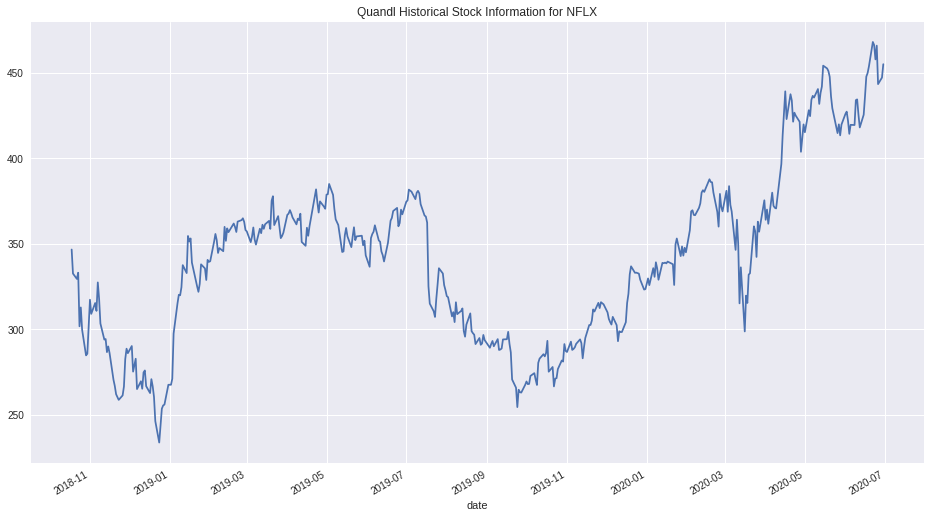

In [12]:
title_string = 'Quandl Historical Stock Information for ' + stock_symbol
stock_quandl['close'].plot(figsize=(16,9), title=title_string)
plt.show()

## Task 3. Develop Strategy and Train Model

### 3.a) Set up the Dataframe for the Trading Model

In [13]:
# Set up the standard column name for modeling
model_template = stock_quandl.loc[:, ['open','close']]
model_template.rename(columns={'open': 'open_price', 'close': 'close_price'}, inplace=True)
if verbose: model_template.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 427 entries, 2018-10-18 to 2020-06-30
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   open_price   427 non-null    float64
 1   close_price  427 non-null    float64
dtypes: float64(2)
memory usage: 10.0 KB


### 3.b) Set up the Analysis Table with Indicators

In [14]:
def trading_ma_crossover(model):
    waitfor_first_entry = True
    for x in range(len(model)):
        if model['ma_change'].iloc[x] > 0:
            model['trade_signal'].iloc[x] = 1  # trade_signal = 1 means we should take a long position
        else:
            model['trade_signal'].iloc[x] = 0  # trade_signal = 0 means we should take a flat position
        if x != 0:
            model['signal_change'].iloc[x] = model['trade_signal'].iloc[x] - model['trade_signal'].iloc[x-1]
            if waitfor_first_entry and (model['signal_change'].iloc[x-1] == 1):
                model['entry_exit'].iloc[x] = model['signal_change'].iloc[x-1]
                waitfor_first_entry = False
            elif (not waitfor_first_entry) and (model['signal_change'].iloc[x-1] != 0):
                model['entry_exit'].iloc[x] = model['signal_change'].iloc[x-1]

In [15]:
model_collection = {}
serial_number = 1

for slow_ma in range(slow_ma_min, slow_ma_max+1, ma_increment):
    for fast_ma in range(fast_ma_min, fast_ma_max+1, ma_increment):
        if (slow_ma - fast_ma) < min_ma_gap: break
        print('Processing model with slow_ma of', slow_ma, 'and fast_ma of', fast_ma)
        model_name = 'EMA_' + str(serial_number).zfill(3) + '_SlowMA_' + str(slow_ma).zfill(2) + '_FastMA_' + str(fast_ma).zfill(2)
        serial_number = serial_number + 1
        trading_model = model_template.copy()
        trading_model['fast_ma'] = trading_model['close_price'].ewm(span=fast_ma).mean()
        trading_model['slow_ma'] = trading_model['close_price'].ewm(span=slow_ma).mean()
        trading_model['ma_change'] = trading_model['fast_ma'] - trading_model['slow_ma']
        trading_model['trade_signal'] = np.zeros(len(trading_model))
        trading_model['signal_change'] = np.zeros(len(trading_model))
        trading_model['entry_exit'] = np.zeros(len(trading_model))
        trading_model = trading_model[model_start_date:model_end_date]
        trading_ma_crossover(trading_model)
        model_collection[model_name] = trading_model.copy()
        print('Model', model_name, 'added to the trading model collection.')

Processing model with slow_ma of 10 and fast_ma of 5
Model EMA_001_SlowMA_10_FastMA_05 added to the trading model collection.
Processing model with slow_ma of 15 and fast_ma of 5
Model EMA_002_SlowMA_15_FastMA_05 added to the trading model collection.
Processing model with slow_ma of 15 and fast_ma of 10
Model EMA_003_SlowMA_15_FastMA_10 added to the trading model collection.
Processing model with slow_ma of 20 and fast_ma of 5
Model EMA_004_SlowMA_20_FastMA_05 added to the trading model collection.
Processing model with slow_ma of 20 and fast_ma of 10
Model EMA_005_SlowMA_20_FastMA_10 added to the trading model collection.
Processing model with slow_ma of 20 and fast_ma of 15
Model EMA_006_SlowMA_20_FastMA_15 added to the trading model collection.
Processing model with slow_ma of 25 and fast_ma of 5
Model EMA_007_SlowMA_25_FastMA_05 added to the trading model collection.
Processing model with slow_ma of 25 and fast_ma of 10
Model EMA_008_SlowMA_25_FastMA_10 added to the trading model 

In [16]:
# List the entry/exit points for each model
for key in model_collection:
    print('List the signal change and entry/exit points for', key)
    if verbose: print(model_collection[key][(model_collection[key].signal_change != 0) | (model_collection[key].entry_exit != 0)])
    else: print(model_collection[key][model_collection[key].entry_exit != 0])
    print()

List the signal change and entry/exit points for EMA_001_SlowMA_10_FastMA_05
            open_price  close_price     fast_ma     slow_ma  ma_change  \
date                                                                     
2019-03-04     359.720       351.04  356.875358  357.609596  -0.734238   
2019-03-13     355.810       361.21  357.524351  356.964175   0.560176   
2019-03-14     360.500       358.82  357.956234  357.301598   0.654636   
2019-03-27     361.000       353.37  360.648004  361.816467  -1.168463   
2019-03-28     354.485       354.61  358.635336  360.506201  -1.870865   
2019-04-02     366.250       367.72  363.206025  362.297566   0.908460   
2019-04-03     369.260       369.75  365.387350  363.652554   1.734796   
2019-04-12     360.690       351.14  360.672328  362.280410  -1.608082   
2019-04-15     350.710       348.87  356.738219  359.842154  -3.103935   
2019-04-22     359.700       377.34  364.380883  362.440073   1.940810   
2019-04-23     375.450       381.89

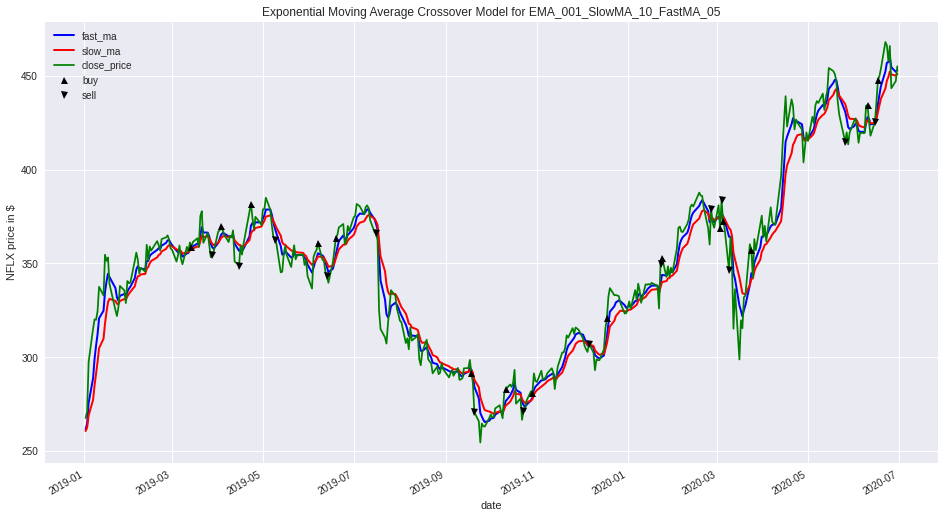

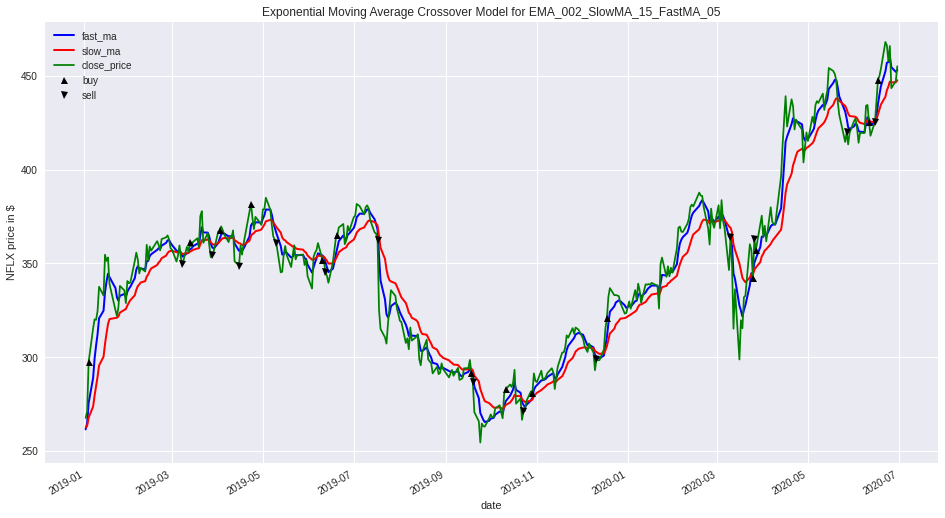

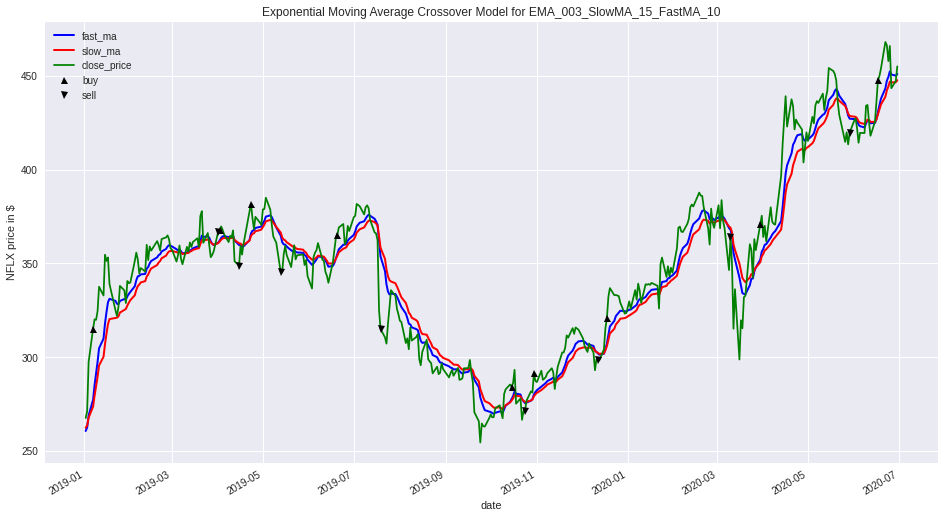

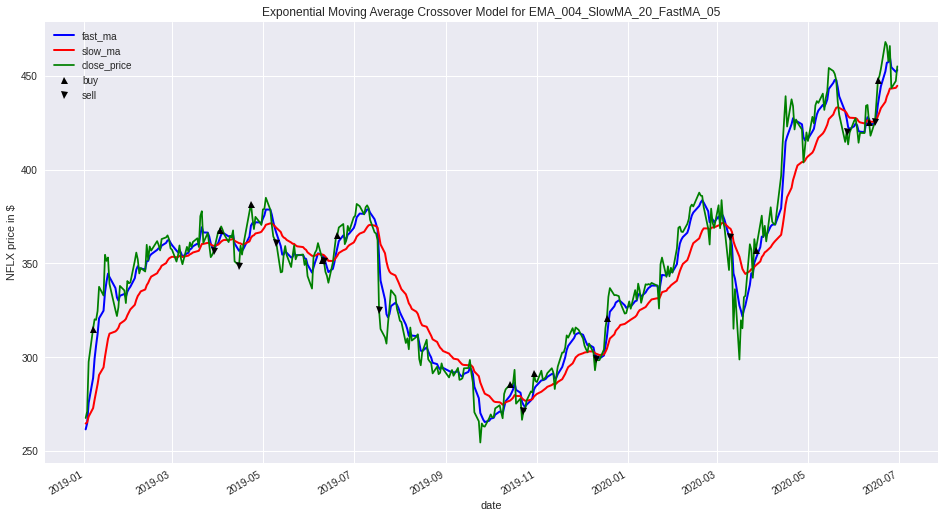

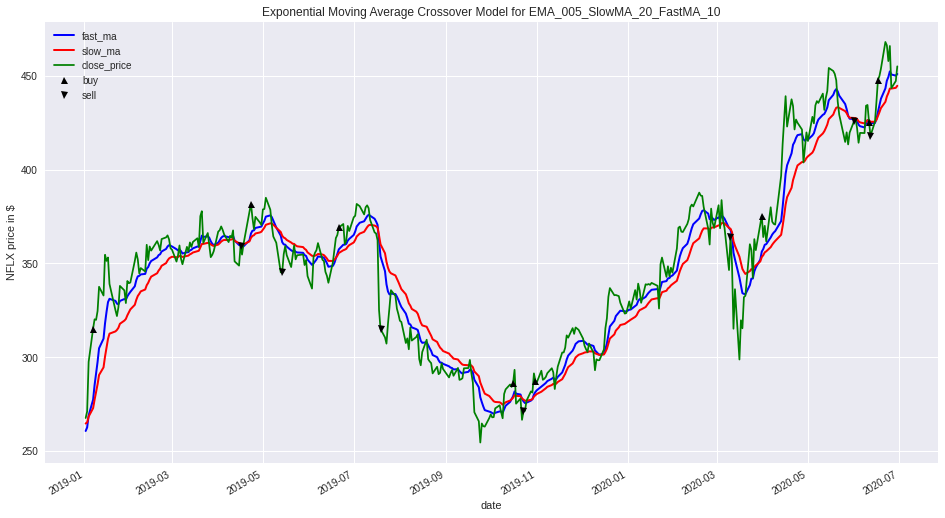

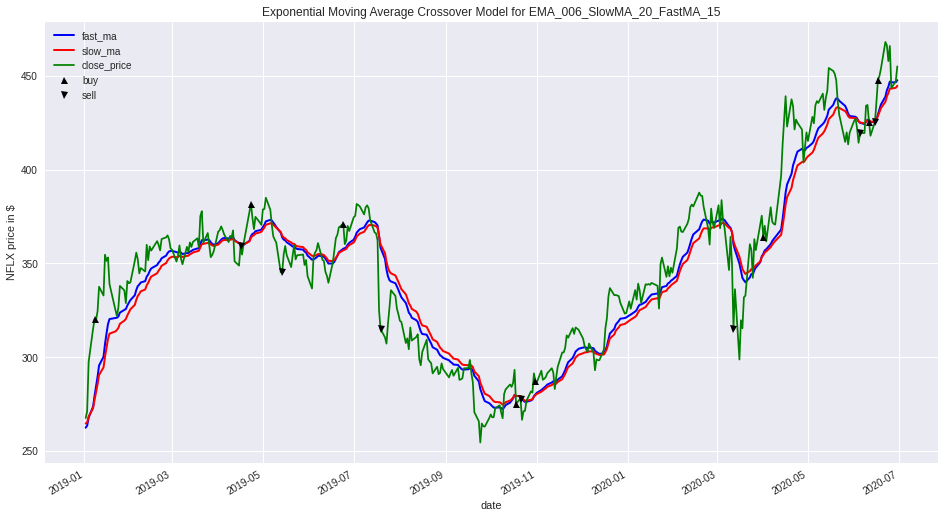

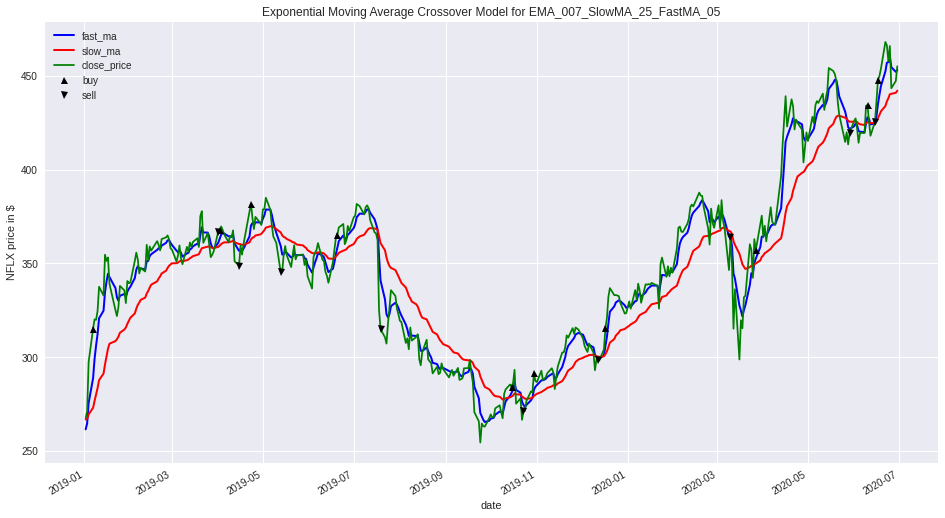

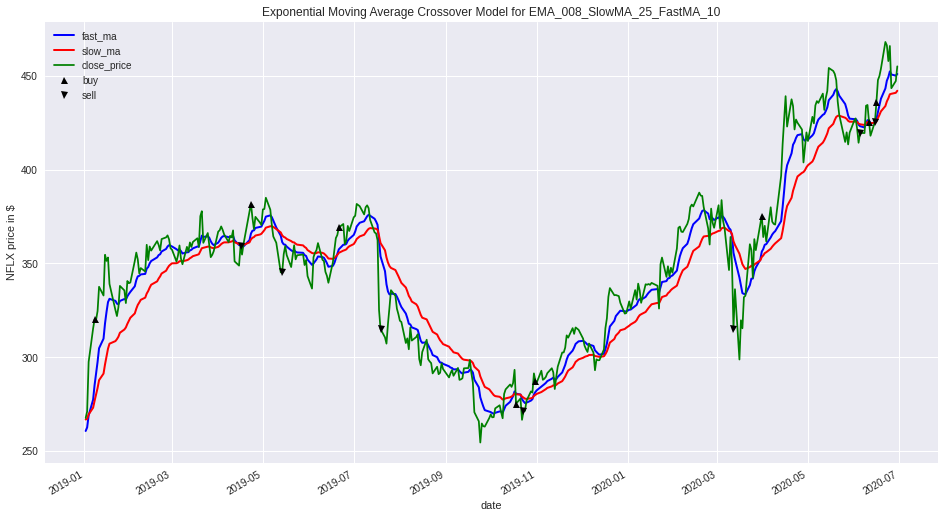

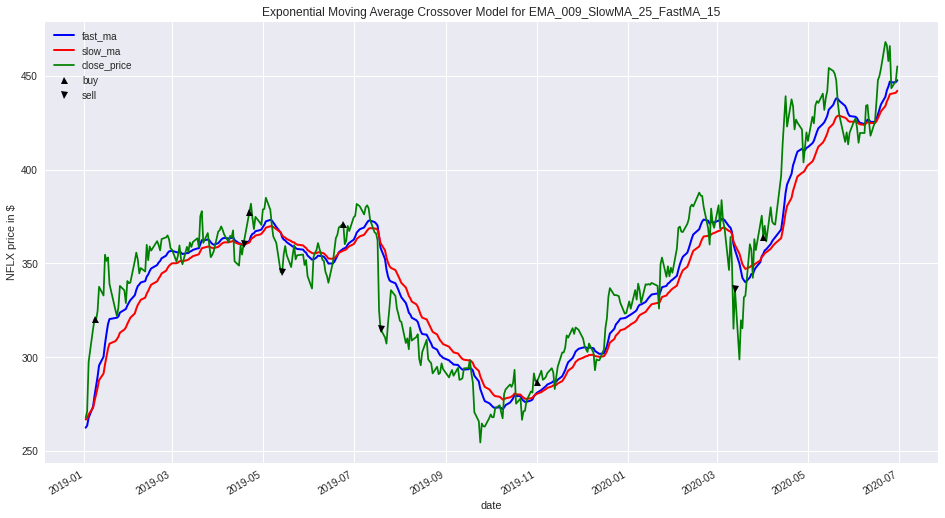

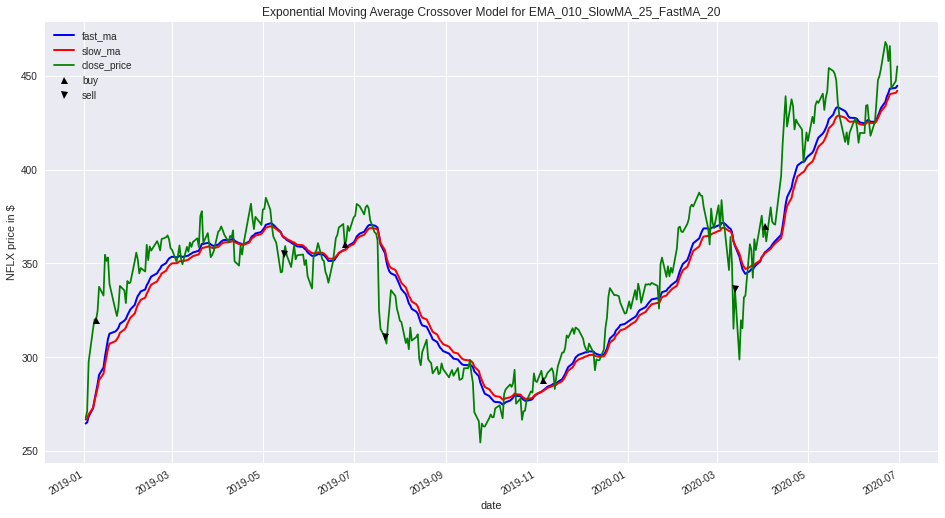

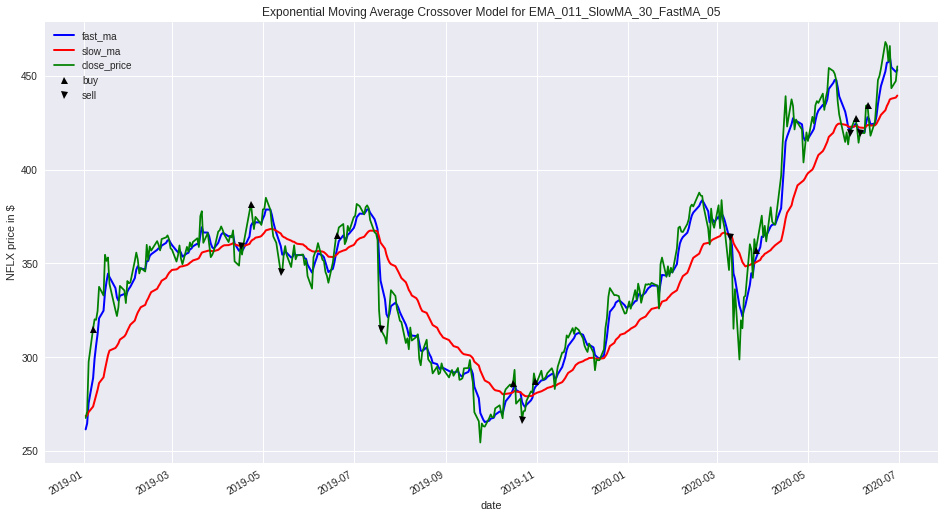

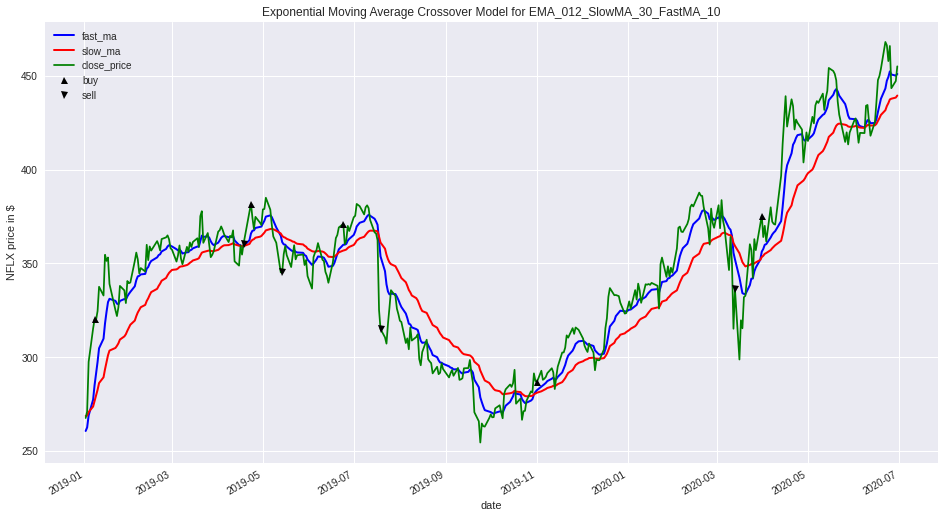

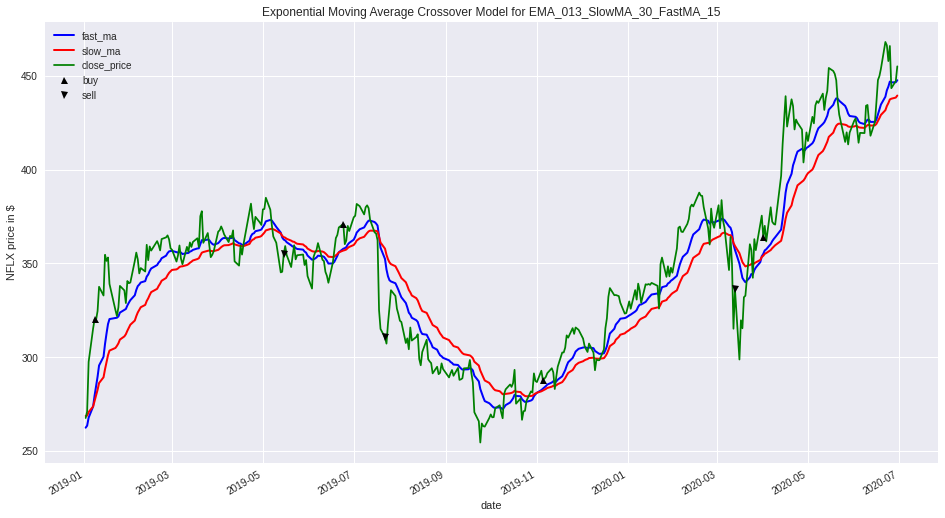

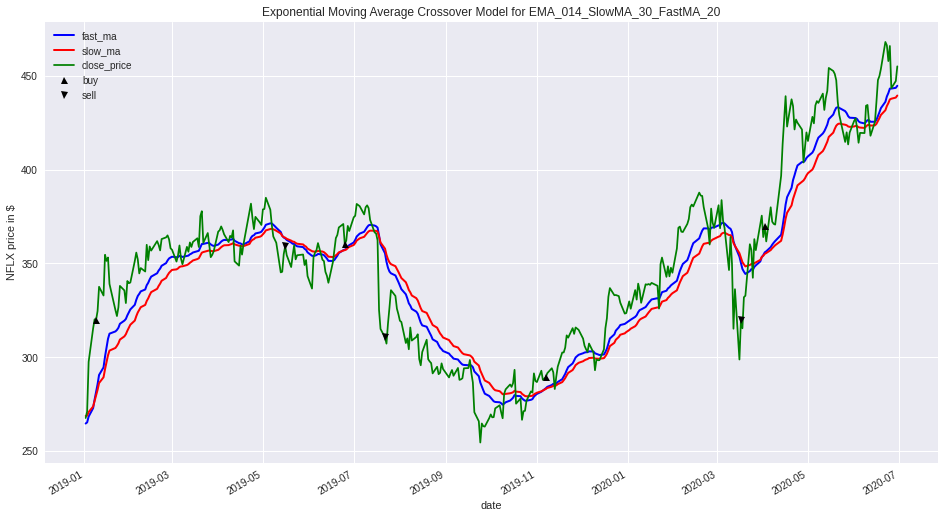

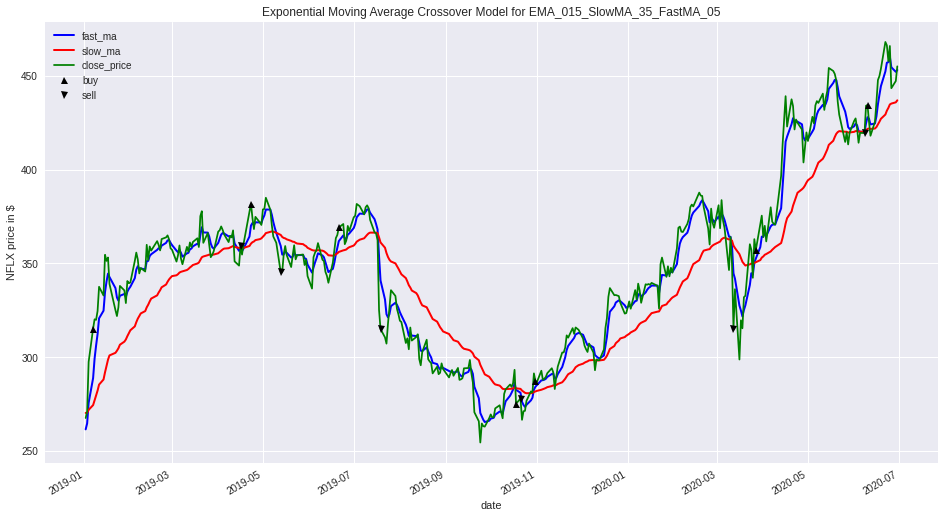

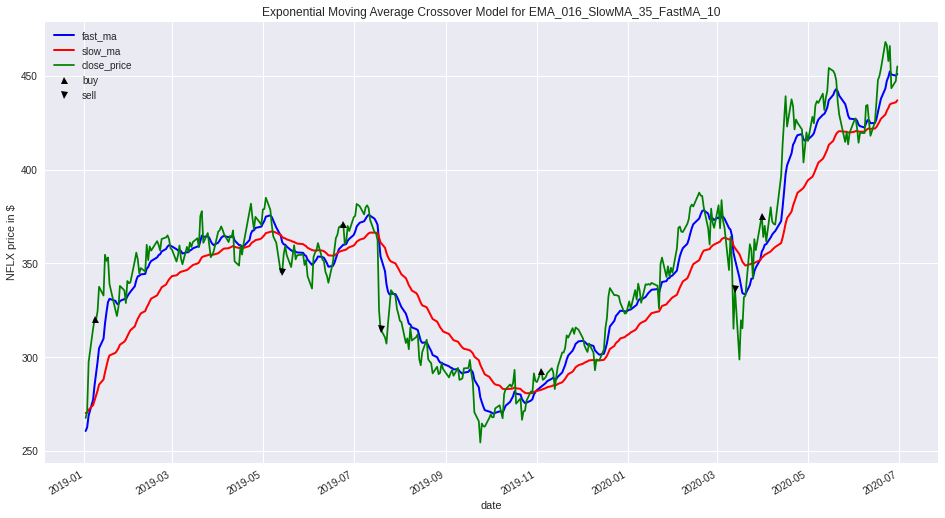

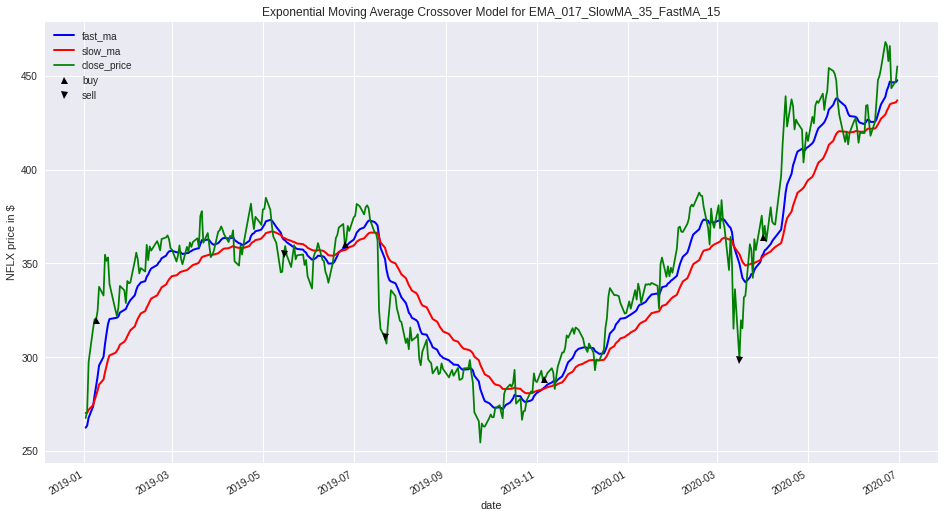

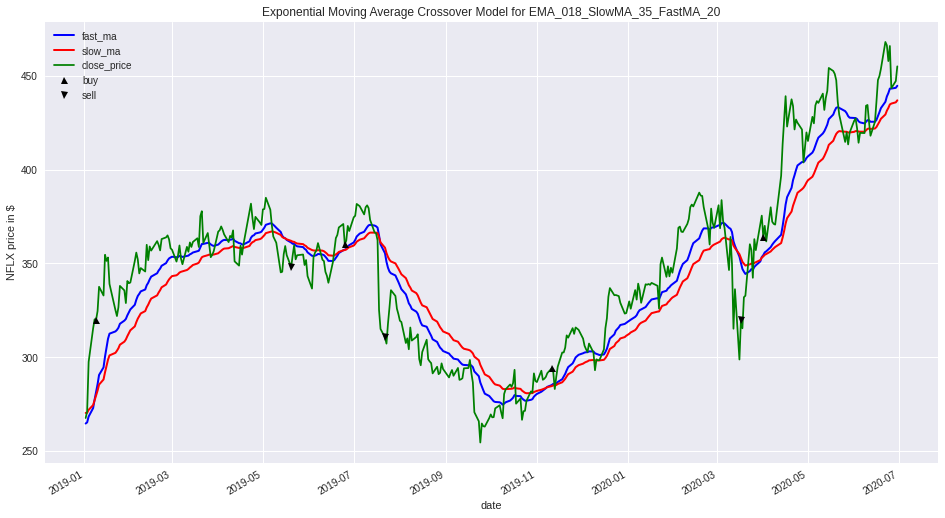

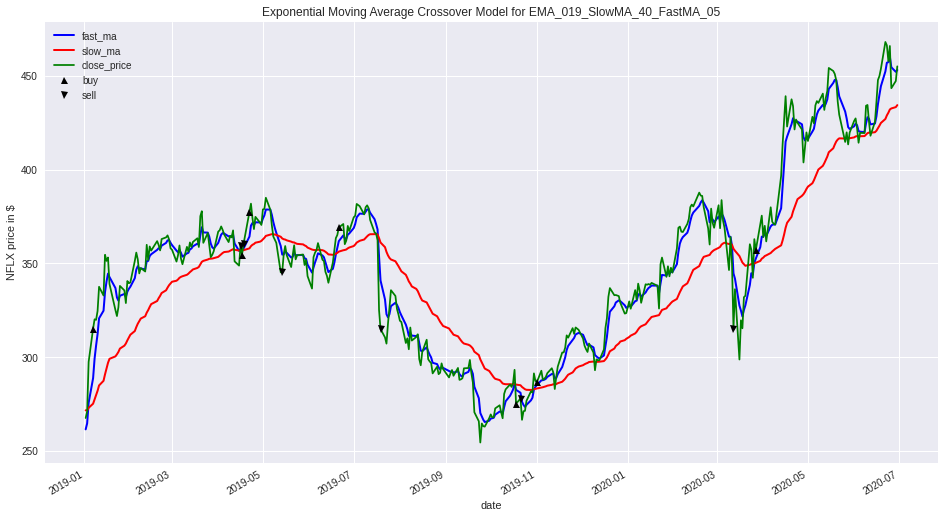

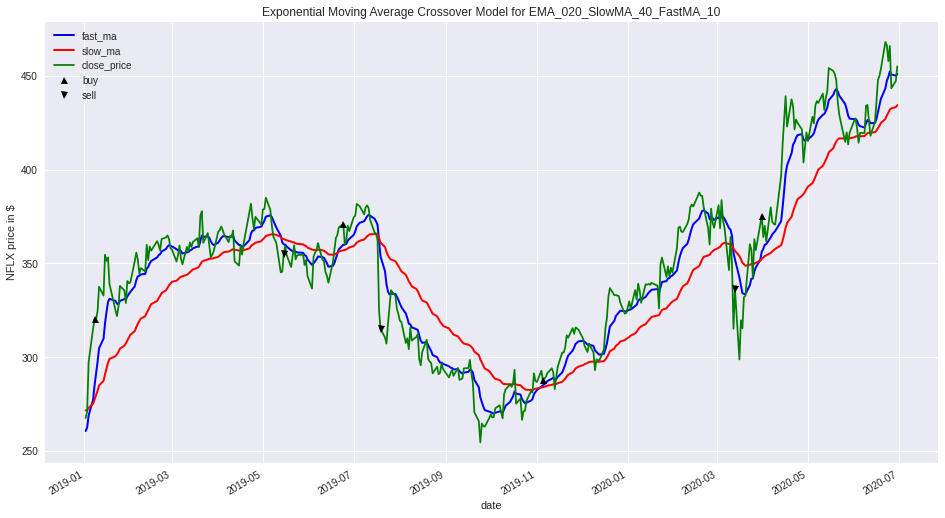

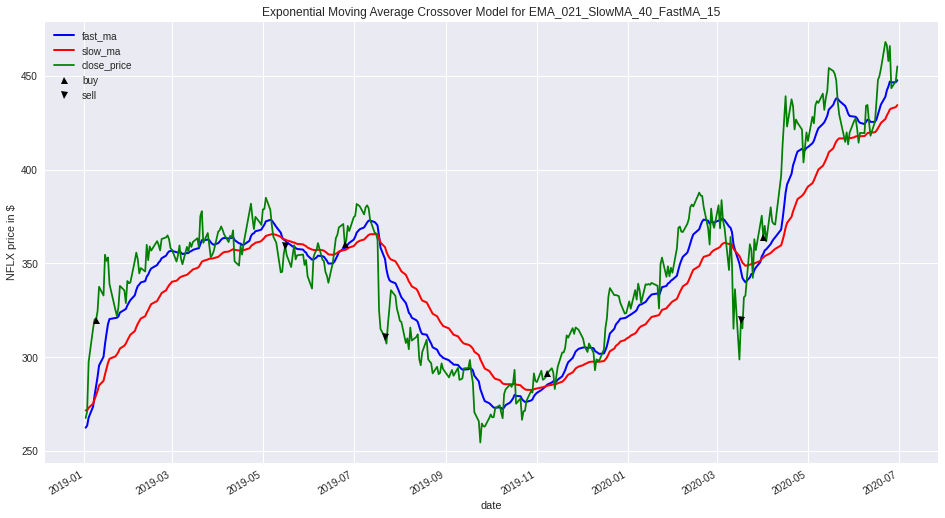

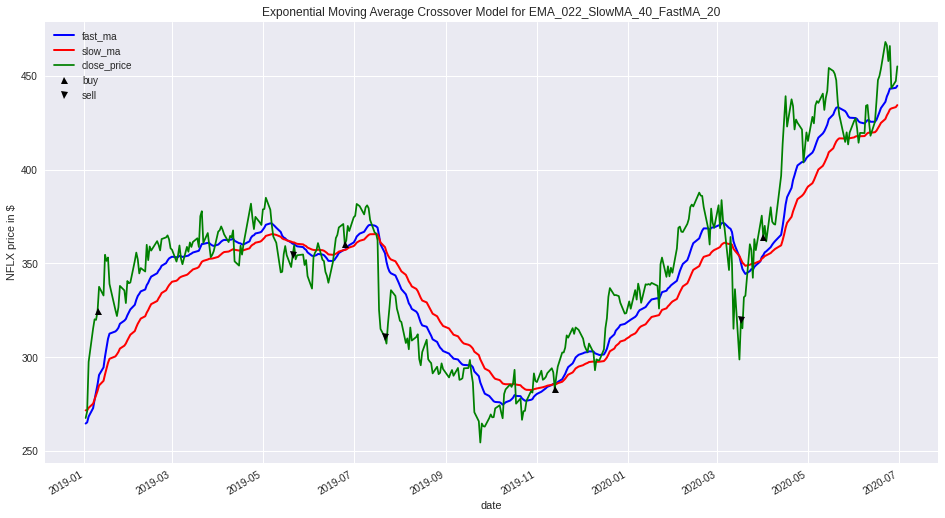

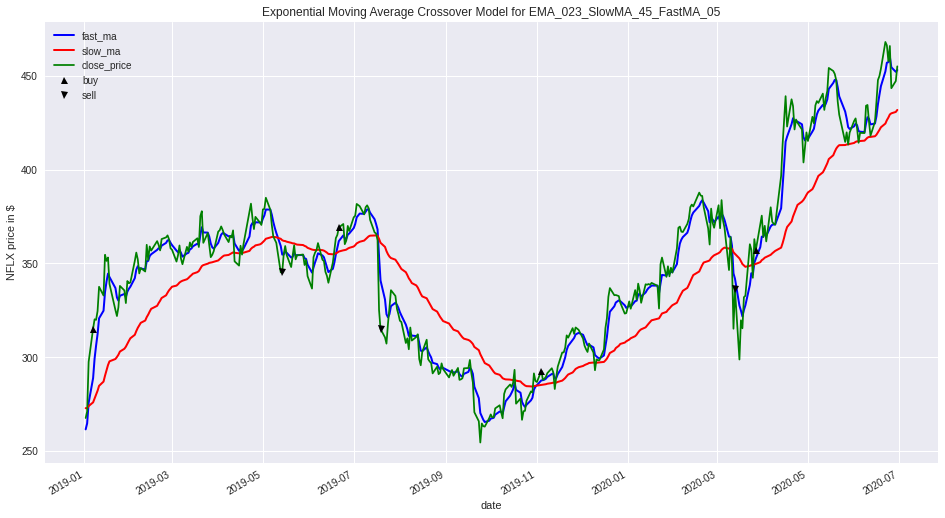

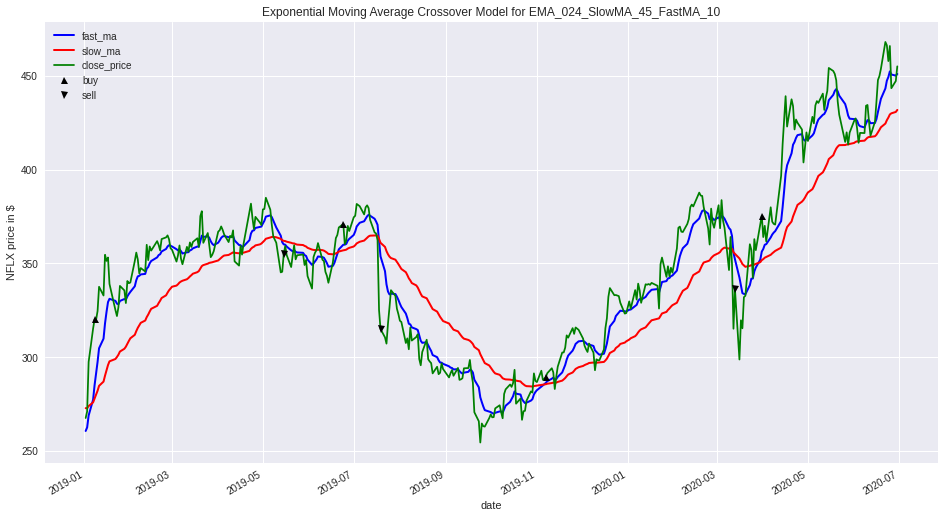

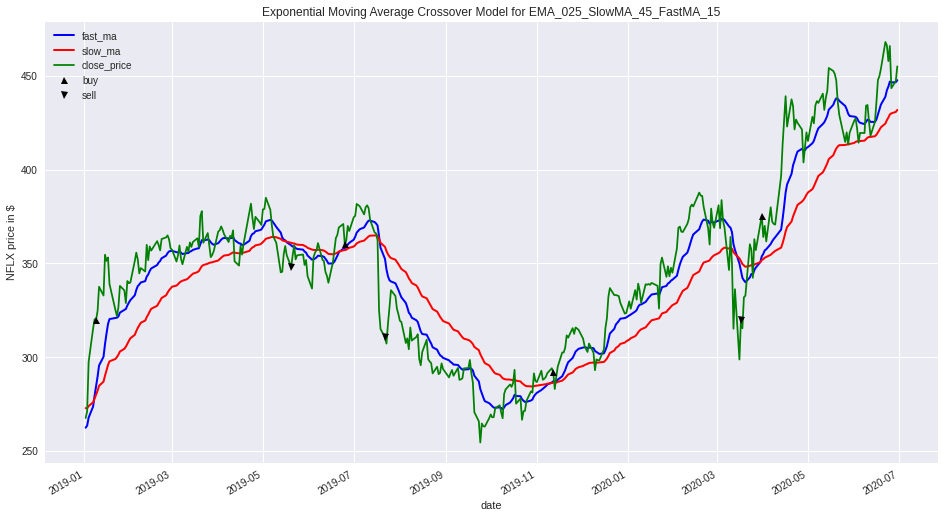

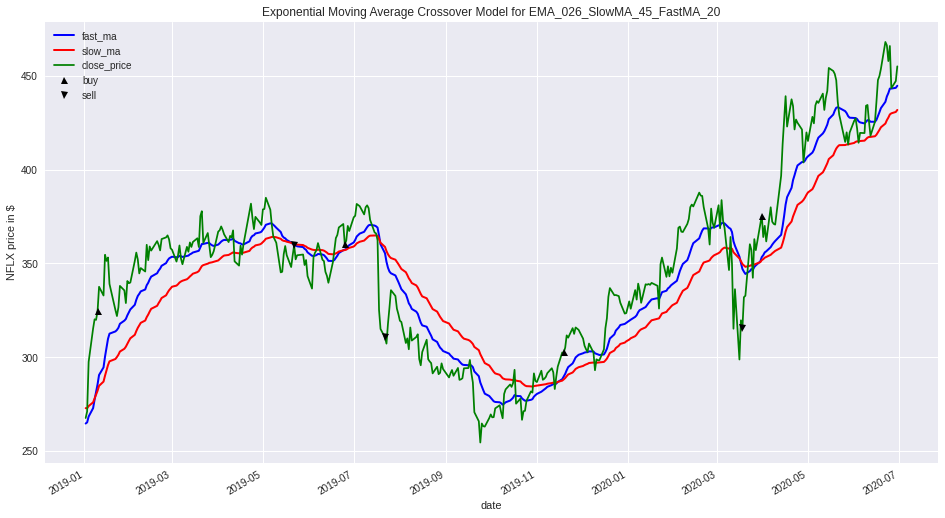

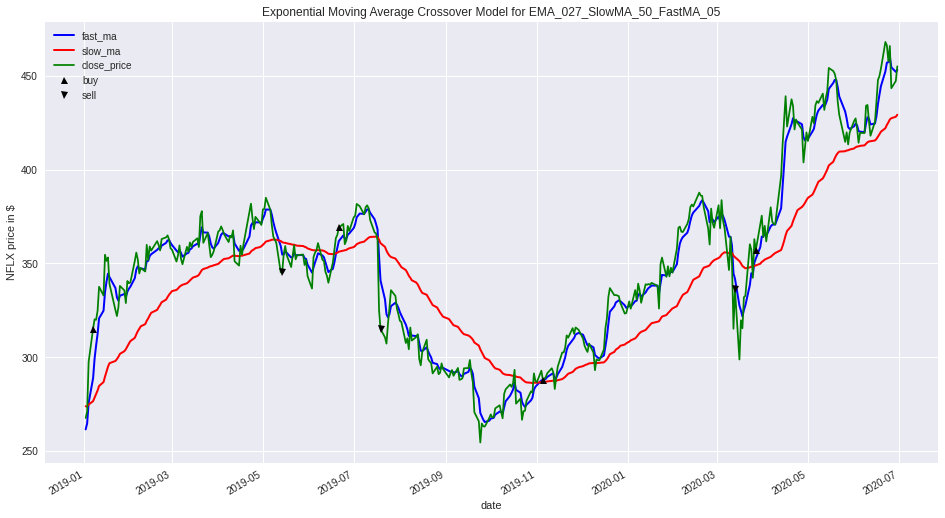

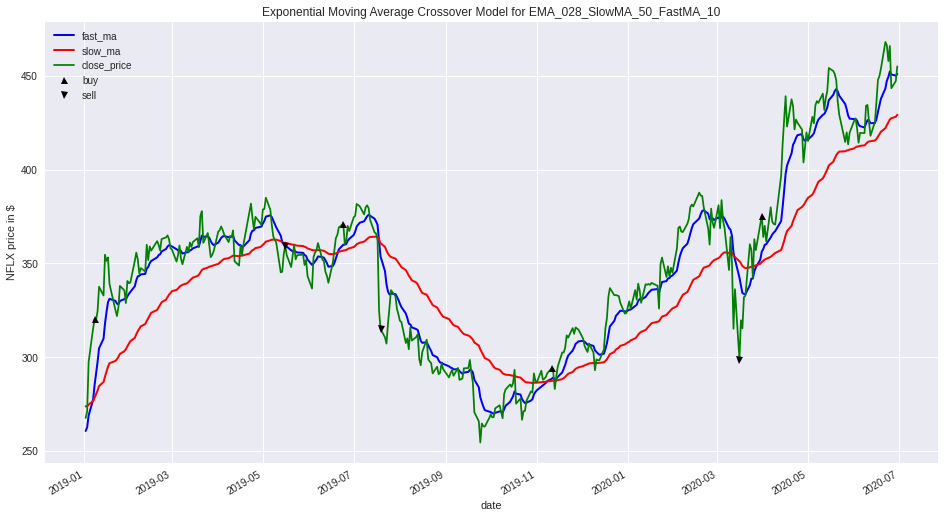

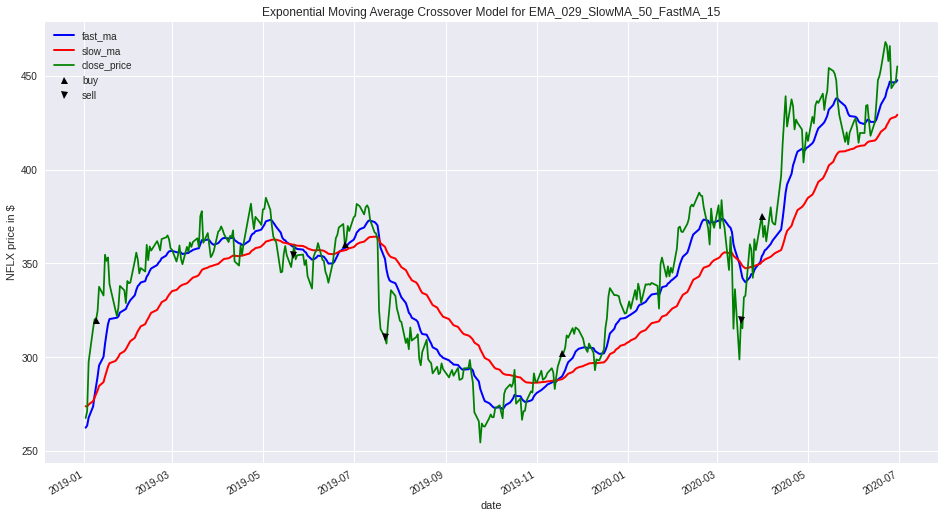

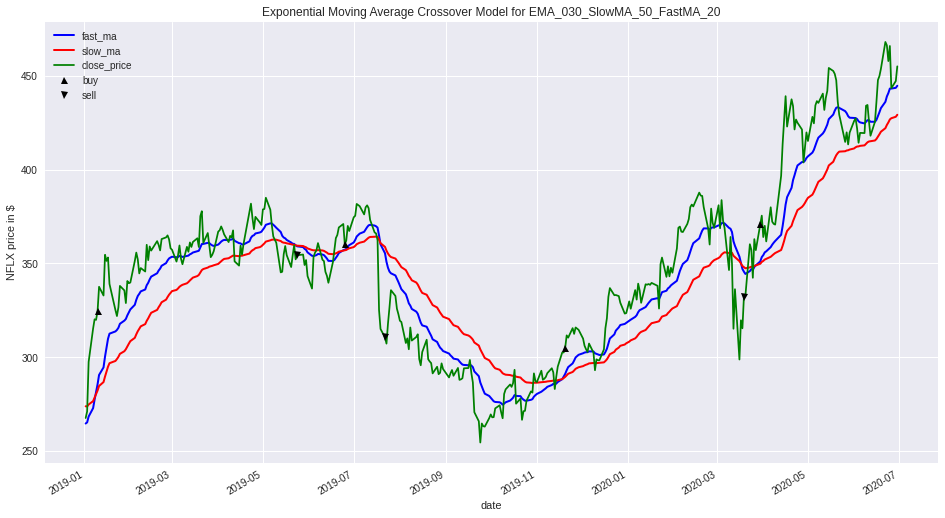

In [17]:
if verbose:
    for key in model_collection:
        graph_data = model_collection[key].copy()
        title_string = "Exponential Moving Average Crossover Model for " + key
        fig = plt.figure(figsize=(16,9))
        ylabel = stock_symbol + ' price in $'
        ax1 = fig.add_subplot(111, ylabel=ylabel, title=title_string)
        graph_data['fast_ma'].plot(ax=ax1, color='b', lw=2.)
        graph_data['slow_ma'].plot(ax=ax1, color='r', lw=2.)
        graph_data['close_price'].plot(ax=ax1, color='g')
        ax1.plot(graph_data.loc[graph_data.entry_exit == 1].index, graph_data.close_price[graph_data.entry_exit == 1], '^', markersize=7, color='k',label='buy')
        ax1.plot(graph_data.loc[graph_data.entry_exit == -1].index, graph_data.close_price[graph_data.entry_exit == -1], 'v', markersize=7, color='k',label='sell')
        plt.legend(loc='upper left')
        plt.show()

## Task 4. Back-test Model

In [18]:
def trading_portfolio_generation(initial_fund, trading_model):
    # Construct a portfolio to track the transactions and returns
    portfolio = pd.DataFrame(index=trading_model.index, columns=['trade_action', 'qty_onhand', 'cost_basis', 'sold_transaction', 'gain_loss', 'cash_onhand', 'position_value', 'total_position', 'accumu_return'])
    portfolio.iloc[0]['trade_action'] = 0
    portfolio.iloc[0]['qty_onhand'] = 0
    portfolio.iloc[0]['cost_basis'] = 0.00
    portfolio.iloc[0]['sold_transaction'] = 0.00
    portfolio.iloc[0]['gain_loss'] = 0.00
    portfolio.iloc[0]['cash_onhand'] = initial_capital
    portfolio.iloc[0]['position_value'] = 0.00
    portfolio.iloc[0]['total_position'] = initial_capital
    portfolio.iloc[0]['accumu_return'] = portfolio.iloc[0]['total_position'] - initial_fund
    recent_cost = 0

    # The conditional parameters below determine how the trading strategy will be carried out
    for i in range(1, len(portfolio)):
        if (trading_model.iloc[i]['entry_exit'] == 1) and (portfolio.iloc[i-1]['qty_onhand'] == 0):
            portfolio.iloc[i]['trade_action'] = 1
            portfolio.iloc[i]['qty_onhand'] = portfolio.iloc[i-1]['qty_onhand'] + portfolio.iloc[i]['trade_action']
            portfolio.iloc[i]['cost_basis'] = trading_model.iloc[i]['open_price'] * portfolio.iloc[i]['trade_action']
            portfolio.iloc[i]['sold_transaction'] = 0.00
            portfolio.iloc[i]['gain_loss'] = 0.00
            portfolio.iloc[i]['cash_onhand'] = portfolio.iloc[i-1]['cash_onhand'] - portfolio.iloc[i]['cost_basis']
            recent_cost = trading_model.iloc[i]['open_price'] * portfolio.iloc[i]['trade_action']
            if verbose: print('BOUGHT QTY:', portfolio.iloc[i]['trade_action'], 'on', portfolio.index[i], 'at the price of', trading_model.iloc[i]['open_price'])
        elif (trading_model.iloc[i]['entry_exit'] == -1) and (portfolio.iloc[i-1]['qty_onhand'] > 0):
            portfolio.iloc[i]['trade_action'] = -1
            portfolio.iloc[i]['qty_onhand'] = portfolio.iloc[i-1]['qty_onhand'] + portfolio.iloc[i]['trade_action']
            portfolio.iloc[i]['cost_basis'] = 0.00
            portfolio.iloc[i]['sold_transaction'] = trading_model.iloc[i]['open_price'] * portfolio.iloc[i]['trade_action'] * -1
            portfolio.iloc[i]['gain_loss'] = (recent_cost + (trading_model.iloc[i]['open_price'] * portfolio.iloc[i]['trade_action'])) * -1
            portfolio.iloc[i]['cash_onhand'] = portfolio.iloc[i-1]['cash_onhand'] + portfolio.iloc[i]['sold_transaction']
            recent_cost = 0.00
            if verbose: print('SOLD QTY:', portfolio.iloc[i]['trade_action'], 'on', portfolio.index[i], 'at the price of', trading_model.iloc[i]['open_price'])
        else:
            portfolio.iloc[i]['trade_action'] = 0
            portfolio.iloc[i]['qty_onhand'] = portfolio.iloc[i-1]['qty_onhand']
            portfolio.iloc[i]['cost_basis'] = portfolio.iloc[i-1]['cost_basis']
            portfolio.iloc[i]['sold_transaction'] = 0.00
            portfolio.iloc[i]['gain_loss'] = 0.00
            portfolio.iloc[i]['cash_onhand'] = portfolio.iloc[i-1]['cash_onhand']
        portfolio.iloc[i]['position_value'] = trading_model.iloc[i]['close_price'] * portfolio.iloc[i]['qty_onhand']
        portfolio.iloc[i]['total_position'] = portfolio.iloc[i]['cash_onhand'] + portfolio.iloc[i]['position_value']
        portfolio.iloc[i]['accumu_return'] = portfolio.iloc[i]['total_position'] - initial_fund

    return portfolio

In [19]:
portfolio_collection = {}

# Build dataframe for reporting model performance summary
performance_summary = pd.DataFrame(columns=['model_name','return_value','return_percent'])

for key in model_collection:
    print('Processing portfolio for model:', key)
    portfolio_collection[key] = trading_portfolio_generation(initial_capital, model_collection[key])
    trade_transactions = portfolio_collection[key][portfolio_collection[key].trade_action != 0]
    print(trade_transactions)
    print('Accumulated profit/loss for one share of stock with initial capital of $%.0f at the end of modeling period: $%.2f' % (initial_capital, portfolio_collection[key].accumu_return[-1]))
    if initial_capital != 0:
        return_percentage = portfolio_collection[key].accumu_return[-1] / initial_capital * 100
        print('Accumulated return percentage based on the initial capital investment: %.2f%%' % (return_percentage))
    else:
        return_percentage = None
    if trade_transactions.iloc[-1]['trade_action'] == 1:
        print('The current status of the model is:', 'Holding a position since', trade_transactions.index.tolist()[-1], '\n')
    else:
        print('The current status of the model is:', 'Waiting to enter since', trade_transactions.index.tolist()[-1], '\n')
    performance_summary = performance_summary.append({'model_name': key, 'return_value': portfolio_collection[key].accumu_return[-1],
                                                      'return_percent': return_percentage}, ignore_index=True)

Processing portfolio for model: EMA_001_SlowMA_10_FastMA_05
BOUGHT QTY: 1 on 2019-03-14 00:00:00 at the price of 360.5
SOLD QTY: -1 on 2019-03-28 00:00:00 at the price of 354.485
BOUGHT QTY: 1 on 2019-04-03 00:00:00 at the price of 369.26
SOLD QTY: -1 on 2019-04-15 00:00:00 at the price of 350.71
BOUGHT QTY: 1 on 2019-04-23 00:00:00 at the price of 375.45
SOLD QTY: -1 on 2019-05-09 00:00:00 at the price of 360.9
BOUGHT QTY: 1 on 2019-06-07 00:00:00 at the price of 357.39
SOLD QTY: -1 on 2019-06-13 00:00:00 at the price of 347.23
BOUGHT QTY: 1 on 2019-06-19 00:00:00 at the price of 361.72
SOLD QTY: -1 on 2019-07-16 00:00:00 at the price of 370.09
BOUGHT QTY: 1 on 2019-09-18 00:00:00 at the price of 294.99
SOLD QTY: -1 on 2019-09-20 00:00:00 at the price of 280.26
BOUGHT QTY: 1 on 2019-10-11 00:00:00 at the price of 284.8
SOLD QTY: -1 on 2019-10-23 00:00:00 at the price of 268.06
BOUGHT QTY: 1 on 2019-10-29 00:00:00 at the price of 281.87
SOLD QTY: -1 on 2019-12-06 00:00:00 at the price 

In [20]:
# Display the model performance summary
performance_summary.sort_values(by=['return_value'], inplace=True, ascending=False)
print(performance_summary)

                     model_name  return_value return_percent
22  EMA_023_SlowMA_45_FastMA_05       143.470           None
26  EMA_027_SlowMA_50_FastMA_05       141.480           None
15  EMA_016_SlowMA_35_FastMA_10       111.480           None
18  EMA_019_SlowMA_40_FastMA_05       107.540           None
19  EMA_020_SlowMA_40_FastMA_10       104.120           None
23  EMA_024_SlowMA_45_FastMA_10       103.410           None
4   EMA_005_SlowMA_20_FastMA_10        99.845           None
10  EMA_011_SlowMA_30_FastMA_05        99.524           None
9   EMA_010_SlowMA_25_FastMA_20        98.360           None
8   EMA_009_SlowMA_25_FastMA_15        97.960           None
29  EMA_030_SlowMA_50_FastMA_20        97.450           None
1   EMA_002_SlowMA_15_FastMA_05        94.990           None
27  EMA_028_SlowMA_50_FastMA_10        94.100           None
11  EMA_012_SlowMA_30_FastMA_10        90.330           None
13  EMA_014_SlowMA_30_FastMA_20        86.350           None
12  EMA_013_SlowMA_30_Fa

In [21]:
# Display the transactions from the top model
top_model = performance_summary.iloc[0]['model_name']
print('The transactions from the top model %s:' % (top_model))
print(portfolio_collection[top_model][portfolio_collection[top_model].trade_action != 0])

The transactions from the top model EMA_023_SlowMA_45_FastMA_05:
           trade_action qty_onhand cost_basis sold_transaction gain_loss  \
date                                                                       
2019-01-07            1          1      302.1                0         0   
2019-05-14           -1          0          0           348.71     46.61   
2019-06-21            1          1        365                0         0   
2019-07-19           -1          0          0            323.4     -41.6   
2019-11-04            1          1        288                0         0   
2020-03-13           -1          0          0           330.51     42.51   
2020-03-27            1          1     359.09                0         0   

           cash_onhand position_value total_position accumu_return  
date                                                                
2019-01-07      -302.1         315.34          13.24         13.24  
2019-05-14       46.61              0      

In [22]:
# Display the entry and exit signals for the top model
print('The trading signal changes from the top model %s:' % (top_model))
print(model_collection[top_model][model_collection[top_model].signal_change != 0])

The trading signal changes from the top model EMA_023_SlowMA_45_FastMA_05:
            open_price  close_price     fast_ma     slow_ma  ma_change  \
date                                                                     
2019-01-04      281.88       297.57  275.730669  274.027704   1.702965   
2019-05-13      352.29       345.26  359.311786  363.147351  -3.835566   
2019-06-20      365.91       365.21  358.288204  355.793544   2.494660   
2019-07-18      323.76       325.21  353.858302  363.121323  -9.263021   
2019-11-01      288.70       286.81  285.152431  284.890309   0.262122   
2020-03-12      326.50       315.25  344.725788  355.997124 -11.271336   
2020-03-26      344.00       362.99  350.341988  349.453249   0.888740   

            trade_signal  signal_change  entry_exit  
date                                                 
2019-01-04           1.0            1.0         0.0  
2019-05-13           0.0           -1.0         0.0  
2019-06-20           1.0            1.0   

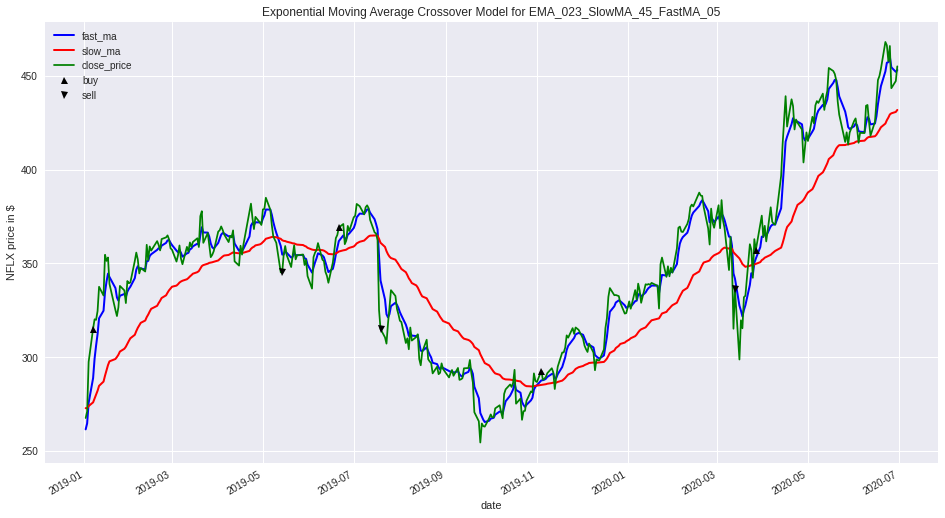

In [23]:
graph_data = model_collection[top_model].copy()
title_string = "Exponential Moving Average Crossover Model for " + top_model
fig = plt.figure(figsize=(16,9))
ylabel = stock_symbol + ' price in $'
ax1 = fig.add_subplot(111, ylabel=ylabel, title=title_string)
graph_data['fast_ma'].plot(ax=ax1, color='b', lw=2.)
graph_data['slow_ma'].plot(ax=ax1, color='r', lw=2.)
graph_data['close_price'].plot(ax=ax1, color='g')
ax1.plot(graph_data.loc[graph_data.entry_exit == 1].index, graph_data.close_price[graph_data.entry_exit == 1], '^', markersize=7, color='k',label='buy')
ax1.plot(graph_data.loc[graph_data.entry_exit == -1].index, graph_data.close_price[graph_data.entry_exit == -1], 'v', markersize=7, color='k',label='sell')
plt.legend(loc='upper left')
plt.show()

## Task 5. Evaluate Performance

In [24]:
best_model = ''
best_return = 0
for key in portfolio_collection:
    if portfolio_collection[key]['accumu_return'][-1] > best_return:
        best_model = key
        best_return = portfolio_collection[best_model]['accumu_return'][-1]
print('The best model found is:', best_model)
print('The best profit/loss for the investing period is: $%.2f' % (best_return))
if initial_capital != 0:
    print('The best return percentage for initial capital is: %.2f%%' % (best_return / initial_capital * 100))

The best model found is: EMA_023_SlowMA_45_FastMA_05
The best profit/loss for the investing period is: $143.47


In [25]:
worst_model = None
worst_return = 0
for key in portfolio_collection:
    if portfolio_collection[key]['accumu_return'][-1] < worst_return:
        worst_model = key
        worst_return = portfolio_collection[worst_model]['accumu_return'][-1]
print('The worst model found is:', worst_model)
print('The worst profit/loss for the investing period is: $%.2f' % (worst_return))
if initial_capital != 0:
    print('The worst return percentage for the initial capital is: %.2f%%' % (worst_return / initial_capital * 100))

The worst model found is: EMA_001_SlowMA_10_FastMA_05
The worst profit/loss for the investing period is: $-5.92


In [26]:
# Calculate the stock's performance for a long-only model
model_template = model_template[model_start_date:model_end_date]
print('The performance of the long-only model from day one is: $%.2f' %(model_template.iloc[-1]['close_price'] - model_template.iloc[0]['open_price']))

The performance of the long-only model from day one is: $195.76


In [27]:
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 0:00:44.677332
